<a href="https://colab.research.google.com/github/AryanSkywalker/AS_P2_English-To-Hindi-Translitertation/blob/main/Encoder_Decoder_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modulation**

In [ ]:
import torch
from torch import nn as nn
from torch import optim as optim
import torch.nn.functional as Functional
from torch.utils.data import Dataset as Dataset

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
import random

import re

import xml.etree.ElementTree as ET

# **Data Preprocessing**

In [ ]:
alphabetArchive = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad = '<pad>'

alphabet2code = {pad:0}
for idx, alphabet in enumerate(alphabetArchive):

  alphabet2code[alphabet] = idx + 1

alphabet2code

{'<pad>': 0,
 'A': 1,
 'B': 2,
 'C': 3,
 'D': 4,
 'E': 5,
 'F': 6,
 'G': 7,
 'H': 8,
 'I': 9,
 'J': 10,
 'K': 11,
 'L': 12,
 'M': 13,
 'N': 14,
 'O': 15,
 'P': 16,
 'Q': 17,
 'R': 18,
 'S': 19,
 'T': 20,
 'U': 21,
 'V': 22,
 'W': 23,
 'X': 24,
 'Y': 25,
 'Z': 26}

In [ ]:
devnagariArchive = [chr(i) for i in range(2304, 2432)]
devArchiveLength = len(devnagariArchive)

devnagari2Code = {pad: 0}
for idx, varn in enumerate(devnagariArchive):

  devnagari2Code[varn] = idx + 1

#devnagari2Code

In [ ]:
filterCommand  = re.compile('[^a-zA-Z ]')

def CleanEnglish(english):

  english = english.replace('-', ' ').replace(',', ' ').upper()
  english = filterCommand.sub('', english)
  return english.split(' ')

def CleanHindi(hindi):

  hindi = hindi.replace('-', ' ').replace(',', ' ')
  betterHindi = ''

  for varn in hindi:

    if varn in hindi or varn == ' ':

      betterHindi += varn

  return betterHindi.split()

# **Dataset Class**

In [ ]:
class English2HindiDataset(Dataset):

  def __init__(self, fileName):

    self.englishArchive, self.hindiArchive = self.ReadXMLCode(fileName, CleanEnglish, CleanHindi)
    self.shuffleIdx = list(range(len(self.englishArchive)))
    random.shuffle(self.shuffleIdx)
    self.shuffleStartIdx = 0

  def __len__(self):

    return len(self.englishArchive)

  def __getitem__(self, idx):

    return self.englishArchive[idx], self.hindiArchive[idx]

  def ReadXMLCode(self, fileName, sourceCleaner, targetCleaner):

    parsedDataset = ET.parse(fileName).getroot()

    X, Y = [], []

    for line in parsedDataset:

      xComponents, yComponents = sourceCleaner(line[0].text), targetCleaner(line[1].text)

      if len(xComponents) != len(yComponents):

        print('Skipping Over: ', line[0].text, ' - ', line[1].text)
        continue

      for xComponent, yComponent in zip(xComponents, yComponents):

        X.append(xComponent)
        Y.append(yComponent)

    return X, Y

  def GetRandomSample(self):

    return self.__getitem__(random.randint(0, len(self.englishArchive)))

  def GetBatchFrom(self, batchSize, array):

    end = self.shuffleStartIdx + batchSize
    batch = []

    if end >= len(array):

      batch = [array[i] for i in self.shuffleIdx[0:end%len(self.englishArchive)]]
      end = len(self.englishArchive)

    return batch + [array[i] for i in self.shuffleIdx[self.shuffleStartIdx:end]]

  def GetBatch(self, batchSize):

    englishBatch = self.GetBatchFrom(batchSize, self.englishArchive)
    hindibatch = self.GetBatchFrom(batchSize, self.hindiArchive)

    self.shuffleStartIdx += batchSize + 1

    if self.shuffleStartIdx >= len(self.englishArchive):

      random.shuffle(self.shuffleIdx)
      self.shuffleStartIdx = 0

    return englishBatch, hindibatch

In [ ]:
trainingSet = English2HindiDataset(os.path.join('.', 'NEWS2012TrainingEnHi13937-1563719470862.xml'))

Skipping Over:  BARHARWA JUNCTION  -  बरहरवा
Skipping Over:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping Over:  TAKHAT SHRI KESGARH SAHIB, ANANDPUR SAHIB (PUNJAB)  -  तखत श्री केसगढ़ साहिब, आनंदपुर साहिब (पंजाब)
Skipping Over:  ORDER OF AGRICULTURAL, COMMERCIAL OR INDUSTRIAL MERIT  -  ऑडर ऑफ एग्रिकल्चरल, कमर्शियल ऑर इंडस्ट्रीयल मेरिट
Skipping Over:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping Over:  SCOTTISH CHURCH COLLEGE, CALCUTTA  -  स्कॉट‍िश चर्च कॉलेज, कैलकटा
Skipping Over:  KING EDWARD VII  -  किंग एडवर्ड
Skipping Over:  SRI RAMAKRISHNA VIDYASHALA, MYSORE  -  श्री रामकृष्ण व‍िद्याशाला, मैसूर
Skipping Over:  DIBANG VALLEY  -  दिबंगवैली
Skipping Over:  SAINT MICHAEL'S ACADEMY, CHENNAI  -  सेंट माइकल्स एकेडमी, चेन्नई
Skipping Over:  CARMEL CONVENT SCHOOL, CHANAKYA PURI  -  कारमेल कॉन्‍वेंट स्कूल, चाणक्य पुरी
Skipping Over:  HEWLETT - PACKARD  -  ह्यूलेट-पैकर्ड
Skipping Over:  SILVERLINE SCHOOL, GHAZIABAD  -  सिल्वरलाइन स्कूल, गाज़ियाबाद
Skipping Over:  APNA K

In [ ]:
testingDataset = English2HindiDataset(os.path.join('.', 'NEWS2012-Ref-EnHi-1000.xml'))

In [ ]:
accelerator = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def RepresentEnglishWord(word):

  representation = torch.zeros((len(word) + 1, 1, len(alphabet2code))).to(accelerator)

  for i, letter in enumerate(word):

    representation[i, 0, alphabet2code[letter]] = 1

  representation[-1, 0, alphabet2code['<pad>']] = 1

  return representation

In [ ]:
RepresentEnglishWord('PARI').shape

torch.Size([5, 1, 27])

In [ ]:
def RepresentHindiWord(word):

  word = list(word)
  #print(word)
  dead = []

  for i in range(len(word)):

    if word[i] in ['\u200d', '\\', "'", '.', '/', '(', ')', ':', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '"', '|']:

      dead.append(i)
  idx = 0
  for i in dead:

    del(word[i-idx])
    idx += 1

  #print(word, ''.join(word), dead)
  
  representation = torch.zeros((len(word) + 1, 1)).to(accelerator)

  for i, varn in enumerate(word):

    representation[i, 0] = devnagari2Code[varn]

  representation[-1, 0] = devnagari2Code['<pad>']
  return representation.long()

In [ ]:
sample = trainingSet.GetRandomSample()

print(sample[0])
print(RepresentEnglishWord(sample[0]))
print(sample[1])
print(RepresentHindiWord(sample[1]))

BARSI
tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
बरसी
tensor([[45],
        [49],
        [57],
        [65],
        [ 0]])


# **Transliterator**

In [ ]:
class TransliterationEngine(nn.Module):

  def __init__(self, inSize, sSize, ySize):

    super(TransliterationEngine, self).__init__()

    self.sSize = sSize
    self.ySize = ySize

    self.encoder = nn.GRU(inSize, sSize)
    self.decoder = nn.GRU(ySize, sSize)

    self.h2o = nn.Linear(sSize, ySize)
    self.Softmax = nn.LogSoftmax(2)

  def forward(self, X, limit, Y=None):

    states, endState = self.encoder(X)

    #print('X Shape: ', X.shape)
    #print('States Shape: ', states.shape)
    #print('endState Shape: ', endState.shape)

    dCurrentState = endState
    dX = torch.zeros(1, 1, self.ySize).to(accelerator)

    y = []

    for i in range(limit):

      #print('dX Shape: ', dX.shape, 'dCurrentState Shape: ', dCurrentState.shape)

      yH, dCurrentState = self.decoder(dX, dCurrentState)
      #print('yH Shape: ', yH.shape, 'dCurrenState Shape: ', dCurrentState.shape)

      yH = self.h2o(dCurrentState)
      #print('Raw YH Shape: ', yH.shape)
      yH = self.Softmax(yH)
      #print('yH Shape: ', yH.shape)

      y.append(yH.view(1, -1))
      #print(y)
      #print(yH.view(1, -1), yH.view(1, -1).shape)

      maxIdx = torch.argmax(yH, 2)

      if Y is not None:

        maxIdx = Y[i].item()

      #print(maxIdx)
      newX = torch.zeros(yH.shape).to(accelerator)
      newX[:, :, int(maxIdx)] = 1
      #print('newX Shape: ', newX.shape)

      dX = newX.detach()

    return y
    

In [ ]:
engine = TransliterationEngine(len(alphabet2code), 256, len(devnagari2Code))

In [ ]:
test = engine(RepresentEnglishWord('INDIA'), 2)

In [ ]:
print(len(test))
for i in test:
  print(list(devnagari2Code.keys())[list(devnagari2Code.values()).index(torch.argmax(i, 1).item())])

2
्
॔


In [ ]:
for i in range(len(test)):

  print(test[i])

# **Transliterator With Attention**

In [ ]:
class AttentiveTransliterationEngine(nn.Module):

  def __init__(self, inSize, sSize, ySize):

    super(AttentiveTransliterationEngine, self).__init__()

    self.sSize = sSize
    self.ySize = ySize

    self.encoder = nn.GRU(inSize, sSize)
    self.decoder = nn.GRU(sSize * 2, sSize)

    self.h2o = nn.Linear(sSize, ySize)
    self.Softmax = nn.LogSoftmax(2)

    self.attentionV = nn.Linear(sSize, 1)
    self.U = nn.Linear(sSize, sSize)
    self.W = nn.Linear(sSize, sSize)

    self.bridge = nn.Linear(ySize, sSize)

  def forward(self, X, limit, Y=None):

    states, endState = self.encoder(X)
    #print(states.shape)
    states = states.view(-1, self.sSize)

    #print('X Shape: ', X.shape)
    #print('States Shape: ', states.shape)
    #print('endState Shape: ', endState.shape)

    dCurrentState = endState
    dX = torch.zeros(1, 1, self.ySize).to(accelerator)
    y = []

    U = self.U(states)
    #print('U Shape: ', U.shape)

    for i in range(limit):

      #print('dX Shape: ', dX.shape, 'dCurrentState Shape: ', dCurrentState.shape)
      #print('gW Shape: ', dCurrentState.view(1, -1).repeat(states.shape[0], 1).shape)
      W = self.W(dCurrentState.view(1, -1).repeat(states.shape[0], 1))
      V = self.attentionV(torch.tanh(U + W))
      #print('V Shape:', V.shape)

      oracle = Functional.softmax(V.view(1, -1), 1)
      #print('Oracle Shape: ', oracle.shape)

      #print('Operation: ', oracle.unsqueeze(0).shape, states.unsqueeze(0).shape)
      betterStates = torch.bmm(oracle.unsqueeze(0), states.unsqueeze(0))
      #print('Better States Shape: ', betterStates[0].shape)
      dX = self.bridge(dX)
      #rint('dX Shape: ', dX[0].shape)
      dX = (torch.cat((dX[0], betterStates[0]), 1)).unsqueeze(0)
      #print('Real dX Shape: ', dX.shape)

      yH, dCurrentState = self.decoder(dX, dCurrentState)

      yH = self.h2o(dCurrentState)
      #print('Raw YH Shape: ', yH.shape)
      yH = self.Softmax(yH)
      #print('yH Shape: ', yH.shape)

      y.append(yH.view(1, -1))

      maxIdx = torch.argmax(yH, 2)

      if Y is not None:

        maxIdx = Y[i].item()

      newX = torch.zeros(yH.shape, device=accelerator)
      newX[:, :, int(maxIdx)] = 1

      dX = newX.detach()

    return y
    

In [ ]:
def Accurize(Model, Set):

  Model.eval()

  accuracy = 0

  for x, y in Set:

    x = RepresentEnglishWord(x)
    y = RepresentHindiWord(y)

    yH = Model(x, y.shape[0])
    correct = 0

    for yh, yC in zip(yH, y):

      yh = yh.argmax(1).tolist()[0]
      
      if yh == yC[0]:

        correct += 1

    accuracy += correct / y.shape[0]
  
  accuracy /= len(Set)

  return accuracy

In [ ]:
def TrainBatch(Model, Optimizer, lossFunction, batchSize, teacherForcing):

  Model.train().to(accelerator)
  
  X, Y = trainingSet.GetBatch(batchSize)
  totalLoss = 0

  Optimizer.zero_grad()
  
  for x, y in zip(X, Y):

    x = RepresentEnglishWord(x)
    y = RepresentHindiWord(y)

    yH = Model(x, y.shape[0], y if teacherForcing else None)
    
    for idx, yh in enumerate(yH):

      loss = lossFunction(yh, y[idx]) / batchSize
      loss.backward(retain_graph=True)
      totalLoss += loss

    del(x)
    del(y)
    del(yH)

  Optimizer.step()

  return totalLoss / batchSize

In [ ]:
def Train(Model, learningRate, momentum, epochs, batchSize, displayFrequency):

  Model = Model.to(accelerator)
  Optimizer = optim.Adam(Model.parameters(), lr=learningRate)
  lossFunction = nn.NLLLoss(ignore_index=-1)

  forceUpto = epochs // 3

  lossArchive = np.zeros(epochs + 1)

  for i in range(epochs):

    lossArchive[i+1] = (lossArchive[i]*i + TrainBatch(Model, Optimizer, lossFunction, batchSize, i<forceUpto ))/(i + 1)

    if i % displayFrequency == displayFrequency - 1:

      print('Epoch Iteration: ', i + 1, 'Loss: ', lossArchive[i])
      plt.figure()
      plt.plot(lossArchive[1:i], '*-')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.show()

      print('\n\n')


In [ ]:
engine = TransliterationEngine(len(alphabet2code), 256, len(devnagari2Code))

In [ ]:
Train(engine, 0.00010, 0.9, 100, 64, 25)

In [ ]:
Accurize(engine, trainingSet)

NameError: ignored

In [ ]:
attentiveEngine = AttentiveTransliterationEngine(len(alphabet2code), 256, len(devnagari2Code))

In [ ]:
attentiveEngine.load_state_dict(torch.load(os.path.join('.', 'ATE 3.pth')))

<All keys matched successfully>

Epoch Iteration:  25 Loss:  0.0470297746360302


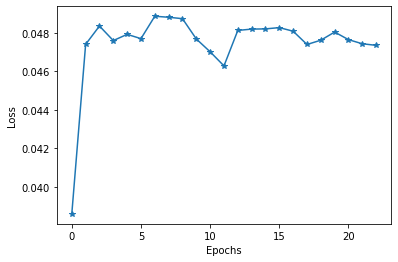




Epoch Iteration:  50 Loss:  0.05601248890161514


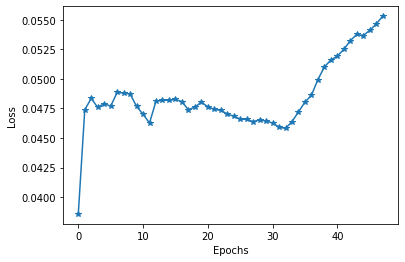




Epoch Iteration:  75 Loss:  0.06239151209592819


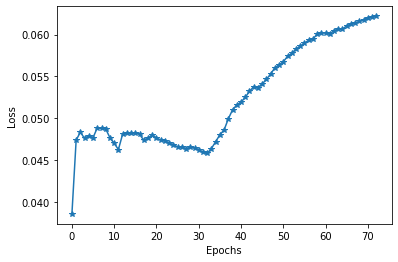




Epoch Iteration:  100 Loss:  0.06399311870336533


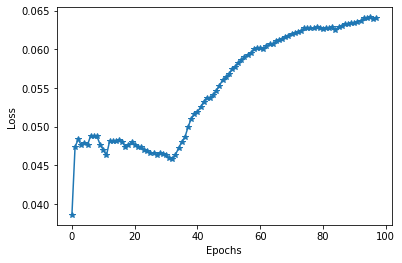

In [ ]:
Train(attentiveEngine, 0.001, 0.9, 100, 64, 25)

In [ ]:
torch.save(attentiveEngine.state_dict(), os.path.join('.', 'ATE 3.pth'))

In [ ]:
Accurize(attentiveEngine, trainingSet)

0.807002087891202

In [ ]:
def Predict(Model, x):

  yH = Model(x, 30)
  y = []

  for yh in yH:

    prediction = torch.argmax(yh, 1)
    
    y.append(list(devnagari2Code.keys())[list(devnagari2Code.values()).index(prediction.item())])

  newY = []
  for g in y:
    newY.append(g)
    if g == '<pad>':
      break

  return newY

In [ ]:
def Transliterate(Model):

  while True:

    x = input()
    if x == 'end': break
    x = RepresentEnglishWord(x.upper())

    newY = Predict(Model, x)

    print(''.join(newY[:-1]))

In [ ]:
Transliterate(attentiveEngine)

Aryan
अर्यन
India
इंडिया
America
अमेरिका
Spain
स्पैन
end


In [ ]:
print('Length of Training Dataset: ', len(trainingSet))
print('Length of Testing Dataset: ' , len(testingDataset))

for i in range(100):

  sample  = testingDataset.GetRandomSample()
  print('Sample: ', sample[0], ' - ', sample[1])

Length of Training Dataset:  20399
Length of Testing Dataset:  1000
Sample:  STENKA  -  स्टेंका
Sample:  KALPAGE  -  कल्पेज
Sample:  GHANVATKAR  -  घनवटकर
Sample:  MEMORIAL  -  मेमोरियल
Sample:  NORTHUMBRIA  -  नार्थउंब्रिया
Sample:  DABHOI  -  दभोई
Sample:  FOND  -  फॉन्ड
Sample:  SIDDIQ  -  सिद्दीक
Sample:  CHEMICAL  -  केमिकल
Sample:  DAMDAMA  -  दमदमा
Sample:  ARNOTT  -  आरनॉट
Sample:  MOULTRIE  -  मॉल्ट्री
Sample:  MAL  -  मल
Sample:  MEDA  -  मेदा
Sample:  MAAR  -  मार
Sample:  KREBS  -  क्रेब्स
Sample:  RESEARCH  -  रिसर्च
Sample:  MEHRAB  -  मेहराब
Sample:  AVELINE  -  एवलाइन
Sample:  OONCH  -  ऊँच
Sample:  MADARI  -  मदारी
Sample:  HEMMINGS  -  हेमिंग्स
Sample:  PHOTOGRAPHY  -  फोटोग्राफी
Sample:  AON  -  एऑन
Sample:  EDMONDS  -  एडमंड्स
Sample:  MARCHAIS  -  मार्केस
Sample:  CHAUDURY  -  चौधरी
Sample:  KAROONGA  -  करूँगा
Sample:  JHUK  -  झुक
Sample:  KISSA  -  किस्सा
Sample:  WHITMAN  -  व्हिटमॅन
Sample:  TSAVO  -  त्सावो
Sample:  SHEETLA  -  शीतला
Sample:  PASCOAL  -  पास्

In [ ]:
def TransliterateSentence(Model):

  sentence = input().split()
  sentenceHindi = []

  for word in sentence:

    word = RepresentEnglishWord(word.upper())

    sentenceHindi.append(''.join(Predict(Model, word)[:-1]))

  print(' '.join(sentenceHindi))

In [ ]:
TransliterateSentence(attentiveEngine)

Mumbai
मुम्बई


# **Not Important**

In [ ]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = trainingSet.GetBatch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        
        input = RepresentEnglishWord(eng_batch[i])
        gt = RepresentHindiWord(hindi_batch[i])
        outputs = net(input, gt.shape[0], gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            #print(output.shape, gt[index].shape, gt[index])
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

In [ ]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model.pt')
    return loss_arr

In [ ]:
def calc_accuracy(net):
    net = net.eval()
    predictions = []
    accuracy = 0
    for i in range(len(trainingSet)):
        eng, hindi = trainingSet[i]
        eng = RepresentEnglishWord(eng)
        gt = RepresentHindiWord(hindi)
        outputs = net(eng, gt.shape[0])
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(trainingSet)
    return accuracy

Iteration 9 Loss 0.3289884328842163


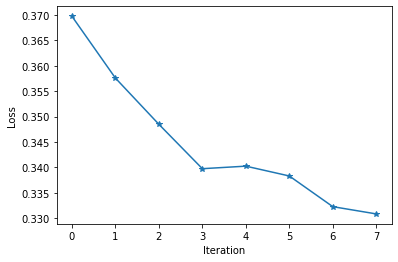




Iteration 19 Loss 0.327423095703125


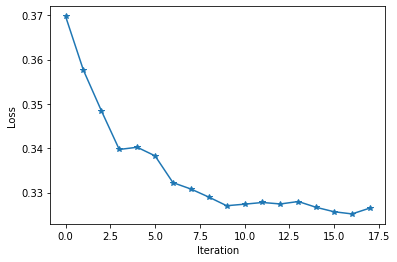




Iteration 29 Loss 0.32444503903388977


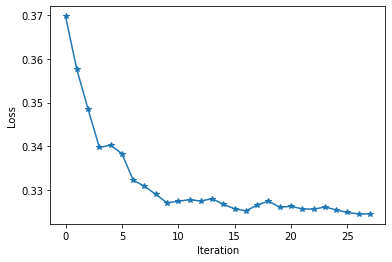




Iteration 39 Loss 0.322243869304657


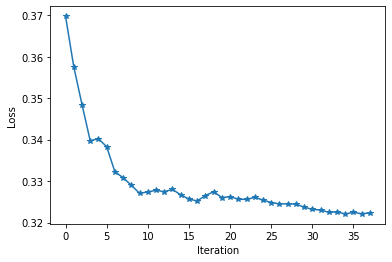




Iteration 49 Loss 0.31965354084968567


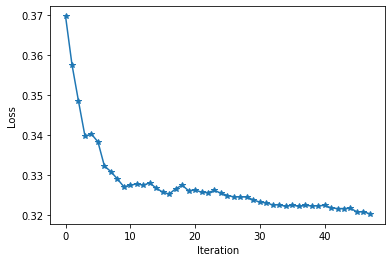

array([0.        , 0.36977777, 0.35759085, 0.34847713, 0.33972469,
       0.34022516, 0.33828792, 0.33223888, 0.33080971, 0.32898843,
       0.32703698, 0.32738507, 0.32776698, 0.32743412, 0.32798204,
       0.32667384, 0.32567564, 0.32518724, 0.32650697, 0.3274231 ,
       0.32602856, 0.32622877, 0.32563952, 0.32556176, 0.32608113,
       0.32541817, 0.32482535, 0.32448673, 0.32449809, 0.32444504,
       0.32370964, 0.32316789, 0.3230077 , 0.32246447, 0.32254988,
       0.32207274, 0.32244265, 0.32211393, 0.32232696, 0.32224387,
       0.32225019, 0.3223474 , 0.32174954, 0.32154596, 0.32155892,
       0.32163426, 0.32071075, 0.32078993, 0.32020918, 0.31965354,
       0.31991833])

In [ ]:
train_setup(engine, 0.001, 50, 64, 0.9, 10)

In [ ]:
calc_accuracy(engine)

0.7900871561152162